In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import sys
from shapely import wkt
from scipy import stats
from tqdm import tqdm
import datetime

from joblib import Parallel, delayed
import multiprocessing


from utils.config import config

sys.path.append(os.path.join(os.getcwd(), "trackintel"))
import trackintel as ti

In [2]:
import matplotlib.pyplot as plt
import matplotlib


matplotlib.rcParams['figure.dpi'] = 300
%matplotlib inline
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13

np.set_printoptions(precision=4, suppress= True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [3]:
selected_user = pd.read_csv(os.path.join(config["quality"], "SBB_user_window_filtered.csv"))["user_id"].unique()
print(selected_user.shape)

(93,)


# Data size

In [4]:
tpls = pd.read_csv(os.path.join(config['raw'], 'tpls.csv'))
tpls = tpls.loc[tpls['userid'].isin(selected_user)]
print("Number of triplegs: {}".format(len(tpls["id"].unique())))

stps = pd.read_csv(os.path.join(config['raw'], 'stps.csv'))
stps = stps.loc[stps['userid'].isin(selected_user)]
print("Number of staypoints: {}".format(len(stps["id"].unique())))

Number of triplegs: 344740
Number of staypoints: 193637


In [5]:
locs = pd.read_csv(os.path.join(config['proc'], 'locs_user_50.csv'))
locs = locs.loc[locs['userid'].isin(selected_user)]

stps_locs = pd.read_csv(os.path.join(config['proc'], 'stps_act_user_50.csv'))
stps_locs = stps_locs.loc[stps_locs['userid'].isin(selected_user)]

print("Number of locations: {} {}".format(len(locs["id"].unique()), len(stps_locs["locid"].unique())) )

trips = pd.read_csv(os.path.join(config['proc'], 'trips.csv'))
trips = trips.loc[trips['userid'].isin(selected_user)]
print("Number of trips: {}".format(len(trips["id"].unique())))

Number of locations: 46489 46489
Number of trips: 181479


# Trip set stability
Trip set is found to be stable for all window size t 

In [6]:
def get_stps():
    stps = pd.read_csv(os.path.join(config['proc'], 'stps_act_user_50.csv'))
    
    stps.rename(columns={"user_id": "userid", "started_at": "startt", "finished_at": "endt"},inplace=True)

    stps['startt'] = pd.to_datetime(stps['startt']).dt.tz_localize(None)
    stps['endt'] = pd.to_datetime(stps['endt']).dt.tz_localize(None)
    return stps

def get_trips():
    trips = pd.read_csv(os.path.join(config['proc'], 'trips.csv'))

    trips.rename(columns={"user_id": "userid", "started_at": "startt", "finished_at": "endt"}, inplace=True)

    trips['startt'] = pd.to_datetime(trips['startt']).dt.tz_localize(None)
    trips['endt'] = pd.to_datetime(trips['endt']).dt.tz_localize(None)
    return trips

def _preprocess(df):
    df.rename(
        columns={"userid": "user_id", "startt": "started_at", "endt": "finished_at", "dur_s": "duration"}, inplace=True
    )
    return df

def _get_all_trace(stps, trips):

    stps = _preprocess(stps)
    trips = _preprocess(trips)
    print("User number:", len(stps["user_id"].unique()), len(trips["user_id"].unique()))

    # merge trips and staypoints
    print("starting merge", stps.shape, trips.shape)
    stps["type"] = "stp"
    trips["type"] = "trip"
    df_all = pd.merge(stps, trips, how="outer")
    print("finished merge", df_all.shape)
    print("*"*50)

    return df_all

stps = get_stps()
trips = get_trips()
all_trace = _get_all_trace(stps, trips)

selected_all_trace = all_trace.loc[all_trace['user_id'].isin(selected_user)]
print(len(stps['user_id'].unique()), len(trips['user_id'].unique()), 
      len(all_trace['user_id'].unique()), len(selected_all_trace['user_id'].unique()))

User number: 139 139
starting merge (259887, 12) (245689, 9)
finished merge (505576, 17)
**************************************************
139 139 139 93


In [7]:

def applyParallel(dfGrouped, func, time_window):
    # multiprocessing.cpu_count()
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group, time_window) for name, group in dfGrouped)
    return pd.concat(retLst)

# get locations within the activity set
def _get_act_locs(df, time_window=5, filter_len=10):
    if df.shape[0] >= 2:
        avg_duration_min = df['duration'].sum() / 60 / time_window
        if avg_duration_min < filter_len:
            len_class = 0
        elif avg_duration_min < 30:
            len_class = 1
        elif avg_duration_min < 60:
            len_class = 2
        elif avg_duration_min < 60 * 6:
            len_class = 3
        elif avg_duration_min < 60 * 12:
            len_class = 4
        elif avg_duration_min < 60 * 24:
            len_class = 5
        elif avg_duration_min < 60 * 48:
            len_class = 6
        else:
            len_class = 7
        return pd.Series([avg_duration_min, len_class], index=['duration','class'])

def get_curr_trips(t, stps, ASet):
    # get the locations in activity set
    valid_stps = stps.loc[stps['locid'].isin(ASet['locid'].unique())]
    
    # consider trip that ends in valid stps
    valid_t = t.loc[t['nstpid'].isin(valid_stps['id'])]
    valid_t = valid_t[['id','length_m','duration','nstpid']]
    
    # enrich with loc id
    valid_t = valid_t.merge(valid_stps[['id','locid']], left_on='nstpid', right_on='id')
    
    valid_t.drop(columns ={"id_y", "nstpid"}, inplace = True)
    
    # enrich with activity set class
    valid_t = valid_t.merge(ASet[['locid', 'class']], on='locid', how='left')
    
    valid_t.rename(columns={'locid':'nloc', 'id_x':'tripid'}, inplace=True)

    return valid_t

def getTripSize(df, time_window):
    weeks = (df['started_at'].max() - df['started_at'].min()).days // 7
    start_date = df['started_at'].min().date()
    
    res = []
    for i in range(0, weeks-time_window+1):
        curr_start = datetime.datetime.combine(start_date + datetime.timedelta(weeks=i), datetime.time())
        curr_end  = datetime.datetime.combine(curr_start + datetime.timedelta(weeks=time_window), datetime.time())
        
        curr = df.loc[(df['started_at'] >= curr_start) & (df['finished_at'] <  curr_end)]
#         get activity set
        curr_stps = curr.loc[curr['type'] == 'stp']
        curr_ASet = curr_stps.groupby('locid', as_index=False).apply(_get_act_locs, time_window=time_window).dropna()
        if curr_ASet.empty:
            continue
        curr_ASet = curr_ASet.loc[curr_ASet['class']>0]
        
#         get activity set
        curr_t = curr.loc[curr['type'] == 'trip']
        curr_tSet = get_curr_trips(curr_t, curr_stps, curr_ASet)
        
#         quality
        curr_quality = curr['duration'].sum()/(curr_end-curr_start).total_seconds()
        
        if curr_quality > 1:
            curr_quality = 1
        
        trip_capa = len(curr_tSet)/time_window
#         get the results
        if curr_quality == 0:
            res.append([i, 0])
        else:
            res.append([i, trip_capa/curr_quality])

    
    res = pd.DataFrame(res, columns=['timeStep','trip_norm'])
    res['user_id'] = df['user_id'].unique()[0]
    return res

In [ ]:
prop = 0.8

time_window_ls = [4, 5, 6, 8, 10, 15, 20, 30, 40]

for time_window in time_window_ls:
    trip_set = applyParallel(selected_all_trace.groupby("user_id"), getTripSize, time_window = time_window)
    # filter by timestep
    temp = trip_set.groupby(["user_id","timeStep"], as_index=False).size()
    user_count = temp.groupby("timeStep").size()
    valid_timestep = (user_count.loc[user_count>=user_count.max()*prop].index).to_numpy()
    trip_set = trip_set[trip_set['timeStep'].isin(valid_timestep)].reset_index(drop=True)

    trip_set['timeStep'] = trip_set['timeStep'].astype(int)
    trip_set['trip_norm'] = trip_set['trip_norm'].astype(int)

    trip_set['timeStep'] = trip_set['timeStep'] + 5

    slope, intercept, rvalue, p_value, std_err = stats.linregress(trip_set['timeStep'],trip_set['trip_norm'])
    print("{} {:.3f} {:.3f} {:.2f} {:.2f} {}".format(time_window, slope, std_err, intercept, p_value, p_value>0.05))
    print("*"*50)

4 -0.002 0.007 23.14 0.78 True
**************************************************
5 -0.001 0.007 23.13 0.86 True
**************************************************
6 -0.002 0.007 23.16 0.81 True
**************************************************
8 -0.007 0.007 23.24 0.33 True
**************************************************
10 -0.009 0.007 23.17 0.23 True
**************************************************
15 -0.011 0.008 22.92 0.16 True
**************************************************


## Trip set plot

In [19]:
trip_set = applyParallel(selected_all_trace.groupby("user_id"), getTripSize, time_window = 5)

# filter by timestep
temp = trip_set.groupby(["user_id","timeStep"], as_index=False).size()
user_count = temp.groupby("timeStep").size()
valid_timestep = (user_count.loc[user_count>=user_count.max()*prop].index).to_numpy()
trip_set = trip_set[trip_set['timeStep'].isin(valid_timestep)].reset_index(drop=True)

trip_set['timeStep'] = trip_set['timeStep'].astype(int)
trip_set['trip_norm'] = trip_set['trip_norm'].astype(int)

trip_set['timeStep'] = trip_set['timeStep'] + 5

slope, intercept, rvalue, p_value, std_err = stats.linregress(trip_set['timeStep'],trip_set['trip_norm'])
print("{:.3f} {:.3f} {:.2f} {:.2f} {}".format(slope, std_err, intercept, p_value, p_value>0.05))

-0.001 0.007 23.13 0.86 True


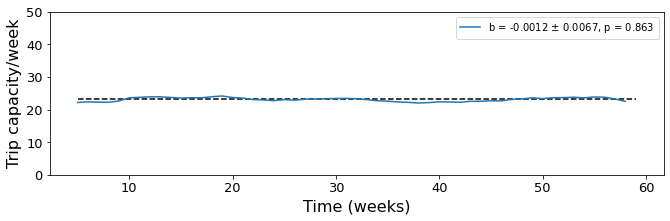

In [23]:
plot_tripSet = trip_set.groupby('timeStep', as_index=False).mean()

slope, intercept, rvalue, p_value, std_err = stats.linregress(trip_set['timeStep'],trip_set['trip_norm'])
plt.figure(figsize=(11,3))
plt.plot(plot_tripSet['timeStep'], plot_tripSet['trip_norm'], label=f'b = {slope:.4f} $\pm$ {std_err:.4f}, p = {p_value:.3f}')

plt.hlines(intercept, 5, 59, 'black',linestyles='dashed',alpha=1)

plt.ylabel("Trip capacity/week",fontsize = 16)
plt.xlabel("Time (weeks)",fontsize = 16)
plt.legend(prop={'size': 12})

plt.ylim([0, 50])
plt.legend()
plt.show()

## Net gain
Net gain for individual showing the trip set for every user in SBB is stable across time

In [25]:
def get_curr_trips(t, stps, ASet):
    # get the locations in activity set
    valid_stps = stps.loc[stps['locid'].isin(ASet['locid'].unique())]
    
    # consider trip that ends in valid stps
    valid_t = t.loc[t['nstpid'].isin(valid_stps['id'])]
    valid_t = valid_t[['id','length_m','duration','nstpid']]
    
    # enrich with loc id
    valid_t = valid_t.merge(valid_stps[['id','locid']], left_on='nstpid', right_on='id')
    
    valid_t.drop(columns ={"id_y", "nstpid"}, inplace = True)
    
    # enrich with activity set class
    valid_t = valid_t.merge(ASet[['locid', 'class']], on='locid', how='left')
    
    valid_t.rename(columns={'locid':'nloc', 'id_x':'tripid'}, inplace=True)

    return valid_t

def applyParallel(dfGrouped, func, time_window):
    # multiprocessing.cpu_count()
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group, time_window) for name, group in dfGrouped)
    return pd.concat(retLst)

def getTripSet(df, time_window):
    weeks = (df['started_at'].max() - df['started_at'].min()).days // 7
    start_date = df['started_at'].min().date()
    
    res = []
    for i in range(0, weeks-time_window+1):
        curr_start = datetime.datetime.combine(start_date + datetime.timedelta(weeks=i), datetime.time())
        curr_end  = datetime.datetime.combine(curr_start + datetime.timedelta(weeks=time_window), datetime.time())
        
        curr = df.loc[(df['started_at'] >= curr_start) & (df['finished_at'] <  curr_end)]
#         get activity set
        curr_stps = curr.loc[curr['type'] == 'stp']
        curr_ASet = curr_stps.groupby('locid', as_index=False).apply(_get_act_locs, time_window=time_window).dropna()
        if curr_ASet.empty:
            continue
        curr_ASet = curr_ASet.loc[curr_ASet['class']>0]
        
#         get trip set
        curr_t = curr.loc[curr['type'] == 'trip']
        curr_tSet = get_curr_trips(curr_t, curr_stps, curr_ASet)
        
        curr_tSet["timeStep"] = i
        
#         get the results
        res.append(curr_tSet[["tripid", "timeStep"]])

    res = pd.concat(res)
    res['user_id'] = df['user_id'].unique()[0]
    return res

time_window = 10
trip_set = applyParallel(selected_all_trace.groupby("user_id"), getTripSet, time_window = time_window)

In [26]:
def net_gain_individual(df):
    set_ls = df.groupby('timeStep')['tripid'].apply(lambda x: set(x)).to_list()
    
    gain_ls = []
    for i in range(len(set_ls)-1):
        add = len(set_ls[i+1] - set_ls[i])
        remove = len(set_ls[i] - set_ls[i+1])
        
        gain_ls.append((add - remove))
    mean = np.mean(gain_ls)
    std = np.std(gain_ls)
    
    stable = np.abs(mean)/std <1
    return stable

stable_num = trip_set.groupby("user_id").apply(net_gain_individual)
print(stable_num.sum()/stable_num.shape[0] * 100)

100.0


# Home location change

**Change of top1 stayed location:**

We calculate the total activity duration of each location in each time window. If the most stayed location of a participant has changed during the study period, the home location of the user might be changed.

In [5]:
stps_locs['startt'] = pd.to_datetime(stps_locs['startt']).dt.tz_localize(None)
stps_locs['endt'] = pd.to_datetime(stps_locs['endt']).dt.tz_localize(None)
stps_locs["duration"] = stps_locs['endt'] - stps_locs['startt']
print(len(stps_locs['userid'].unique()))

93


In [6]:
def get_top1_changed_flag(df):
    window_size = 10

    weeks = (df["endt"].max() - df["startt"].min()).days // 7
    start_date = df["startt"].min().date()
    
    top1_ls = []
    for i in range(0, weeks - window_size + 1):
        curr_start = datetime.datetime.combine(start_date + datetime.timedelta(weeks=i), datetime.time())
        curr_end = datetime.datetime.combine(curr_start + datetime.timedelta(weeks=window_size), datetime.time())

        # current trip
        curr = df.loc[(df["startt"] >= curr_start) & (df["endt"] < curr_end)]
        
        top1_loc = curr.groupby("locid")["duration"].sum().sort_values(ascending=False).head(1).index.values[0]
        top1_ls.append(top1_loc)
    
    if np.unique(top1_ls).shape[0] == 1:
        return False
    else:
        return True

change_df = stps_locs.groupby("userid").apply(get_top1_changed_flag)
changed_user = change_df.loc[change_df==True]
changed_user.index.values

array([1608, 1620, 1624, 1630, 1631, 1650, 1651, 1681, 1695, 1721, 1736,
       1757, 1812], dtype=int64)

**Extract typical user for visualization:**

The staypoints and trips of the top1 location changed users are extracted for analysing

In [7]:
trips['startt'] = pd.to_datetime(trips['startt']).dt.tz_localize(None)
trips['endt'] = pd.to_datetime(trips['endt']).dt.tz_localize(None)
trips["duration"] = trips['endt'] - trips['startt']

In [9]:
def to_geopandas(df):
    df['geom'] = df['geom'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geom')
    gdf.set_crs("EPSG:4326", inplace=True)
    gdf["startt"] = gdf["startt"].astype(str)
    gdf["endt"] = gdf["endt"].astype(str)

    return gdf

for user in changed_user.index.values:
    user_stps = stps.loc[stps["userid"]==user].copy()
    user_trips = trips.loc[trips["userid"]==user].copy()
    
    user_stps.to_csv(os.path.join(config['visualization'], f'{user}_stps.csv'))
    user_trips.to_csv(os.path.join(config['visualization'], f'{user}_trips.csv'))

    to_geopandas(user_stps).to_file(os.path.join(config['visualization'], f'{user}_stps.shp'))
